In [39]:
import os
import csv
import pickle
import glob
import cv2
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from tensorflow import keras
import tensorflow as tf
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

In [2]:
labels_dir = os.getcwd()+'\labels'
data_dir = os.getcwd()+'\Data'
labels_list = os.listdir(labels_dir)
data_list = os.listdir(data_dir)

In [3]:
txt = []
for index in range(0, len(labels_list)): #start from new dataset
    label = labels_list[index]
    txt.append(os.path.join(labels_dir, label))

In [4]:
dt = []
for index in range(0, len(data_list)): #start from new dataset
    d = data_list[index]
    dt.append(os.path.join(data_dir, d))

In [5]:
def extract_label(txt):
    clean_vars = []
    with open(txt, 'r') as csvfile:
    # with open(r'C:\Users\phili\techlabs\eth_sms\labels\SMS_064_Körperlage.txt', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';', quotechar=",")
        for row in reader:
            # clean up your file here and append it to the list
            clean_vars.append([char for char in row if char])

    my_string = ' '.join(map(str,clean_vars[1]))
    start_date = my_string.split(":",1)[1]
    start = start_date[0:11] #get only the date

    list = clean_vars[6:] #get the labels
    df = pd.DataFrame(list, columns=['time','Position'])
    # start = pd.to_datetime(start, format='%d%m%Y')
    df.time = df.time.str.replace(',','.')
    df.time = df.time.str.lstrip()
    # df.time = df.time.str.replace(" ", "", n = 1)
    df.time = df.time.apply(lambda x: ' '.join((start, x))) # add date
    # df.time= pd.to_datetime(df.time)
    # morning_hour = df.iloc[-1]['time'].hour '%m/%d/%Y %H:%M:%S.%f'
    df.time = pd.to_datetime(df['time'], format=' %d.%m.%Y %H:%M:%S.%f')
    df.time = pd.to_datetime(df.time).apply(lambda x: x + pd.DateOffset(days=1) if x.hour <= 10 else x) # corect the date after 0 o'clock
    # df.time = pd.to_datetime(df.time,format='%Y/%m/%d %H:%M:%S.%f')
    # df_end = df[df['Position']!=' A']
    df_end = df
    df_end = df_end.reset_index().drop(columns= ['index'])
    df_end['end'] = df_end['time'].shift(-1) # get the duration
    df_end['end'] = np.where(df_end['end'].isnull(), df_end['time'], df_end['end'])
    return df_end


In [6]:
def extract_label_old(txt):
    clean_vars = []
    with open(txt, 'r') as csvfile:
    # with open(r'C:\Users\phili\techlabs\eth_sms\labels\SMS_064_Körperlage.txt', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';', quotechar=",")
        for row in reader:
            # clean up your file here and append it to the list
            clean_vars.append([char for char in row if char])
    info = clean_vars[483:]
    df = pd.DataFrame(info)
    df[0] = df[0].str.replace('\t',',')
    dfnew = df[0].str.split(',', expand=True)
    df_end = dfnew[dfnew[3].str.contains('POSITION')].reset_index().drop(columns=['index',0,1,4,5]).rename({2: 'time', 3: 'Position'}, axis=1)
    df_end.time = pd.to_datetime(df_end['time'], format='%Y.%m.%dT%H:%M:%S.%f')
    df_end['end'] = df_end['time'].shift(-1) # get the duration
    df_end['end'] = np.where(df_end['end'].isnull(), df_end['time'], df_end['end'])
    return df_end



In [7]:
def get_data(dt):
    data = pd.read_pickle(dt)
    data = data.reset_index()
    data = data.rename(columns={"index": "time", "matData": "pressure"})
    data['time'] = pd.to_datetime(data['time'],unit='ms')
    df_new = data.drop_duplicates(subset='time', keep='first').reset_index().drop(columns= ['index']) #drop with exact date and hours and get the first one
    df_new['end'] = df_new['time'].shift(-1) # get the duration
    df_new['end'] = np.where(df_new['end'].isnull(), df_new['time'], df_new['end'])
    df_new['time'] = df_new['time'] + pd.Timedelta(hours=1)
    df_new['end'] = df_new['end'] + pd.Timedelta(hours=1)
    df_new['label'] = 0
    return df_new

In [8]:
def get_data_old(dt):
    data = pd.read_pickle(dt)
    data = data.reset_index()
    data = data.rename(columns={"index": "time", "matData": "pressure"})
    data['time'] = pd.to_datetime(data['time'],unit='ms')
    df_new = data.drop_duplicates(subset='time', keep='first').reset_index().drop(columns= ['index']) #drop with exact date and hours and get the first one
    df_new['end'] = df_new['time'].shift(-1) # get the duration
    df_new['end'] = np.where(df_new['end'].isnull(), df_new['time'], df_new['end'])
    df_new['time'] = df_new['time'] 
    df_new['end'] = df_new['end'] 
    df_new['label'] = 0
    return df_new

In [9]:
def get_label(txt,dt):
    if txt[-10:-4]=='Events':
        df_end = extract_label_old(txt)
        df_new = get_data_old(dt)
    else:
        df_end = extract_label(txt)
        df_new = get_data(dt)
    # df_new = get_data(dt)
    for i in range(len(df_new['end'])):
        for j in range(len(df_end['time'])):

            if (df_new['time'][i] >= df_end['time'][j]) & (df_new['time'][i] <= df_end['end'][j]):
                df_new['label'][i] = df_end['Position'][j]
                break
            else:
                continue

    

    return df_new, df_end

Rücken or Not Rücken -> Feature Extraction -> KMeans

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\4249975297.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


13/13 [==============================] - 1s 43ms/step - loss: 1.4411 - accuracy: 0.5000
Epoch 2/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2642 - accuracy: 0.5175
Epoch 3/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2578 - accuracy: 0.4978
Epoch 4/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2568 - accuracy: 0.5006
Epoch 5/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2542 - accuracy: 0.4950
Epoch 6/20
13/13 [==============================] - 1s 42ms/step - loss: 0.2524 - accuracy: 0.4990
Epoch 7/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2530 - accuracy: 0.4827
Epoch 8/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2518 - accuracy: 0.4996
Epoch 9/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2512 - accuracy: 0.5003
Epoch 10/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2515 - accuracy: 0.4900
Epoch 11/20
13/13 [=

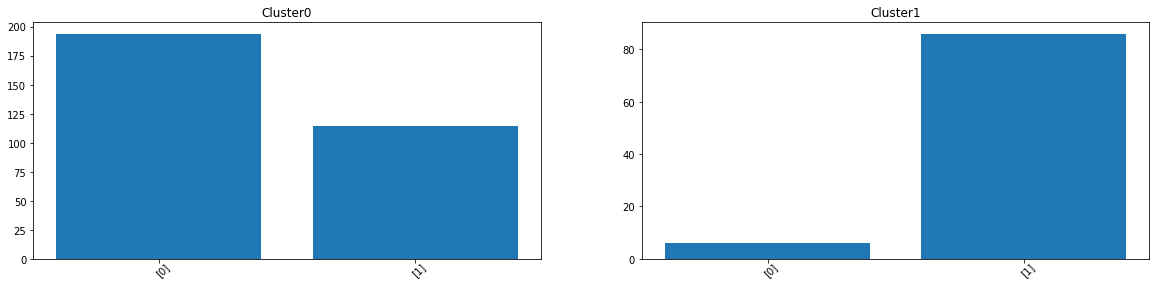

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\4249975297.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


13/13 [==============================] - 1s 43ms/step - loss: 0.2510 - accuracy: 0.4909
Epoch 2/20
13/13 [==============================] - 1s 42ms/step - loss: 0.2510 - accuracy: 0.4890
Epoch 3/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2510 - accuracy: 0.4936
Epoch 4/20
13/13 [==============================] - 1s 42ms/step - loss: 0.2504 - accuracy: 0.5005
Epoch 5/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2507 - accuracy: 0.4847
Epoch 6/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2508 - accuracy: 0.4865
Epoch 7/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2505 - accuracy: 0.4880
Epoch 8/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2505 - accuracy: 0.4961
Epoch 9/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2501 - accuracy: 0.5018
Epoch 10/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2505 - accuracy: 0.4940
Epoch 11/20
13/13 [=

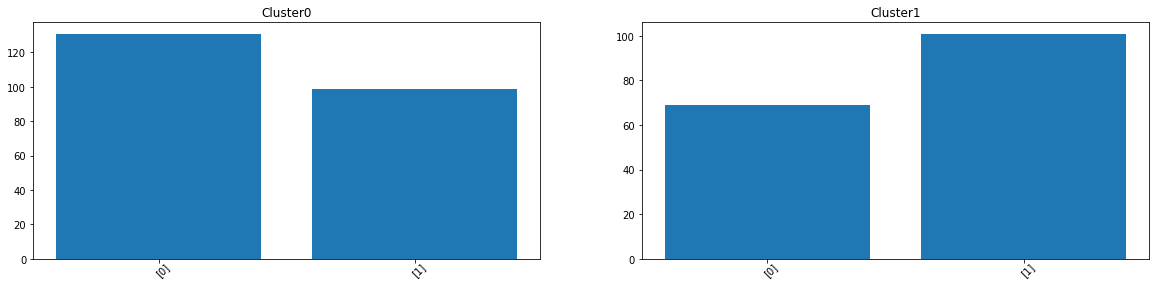

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\4249975297.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


13/13 [==============================] - 1s 46ms/step - loss: 0.2508 - accuracy: 0.4823
Epoch 2/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2505 - accuracy: 0.4850
Epoch 3/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2510 - accuracy: 0.4871
Epoch 4/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2506 - accuracy: 0.4808
Epoch 5/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4963
Epoch 6/20
13/13 [==============================] - 1s 46ms/step - loss: 0.2504 - accuracy: 0.4843
Epoch 7/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4952
Epoch 8/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2505 - accuracy: 0.4797
Epoch 9/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2507 - accuracy: 0.4839
Epoch 10/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2503 - accuracy: 0.4887
Epoch 11/20
13/13 [=

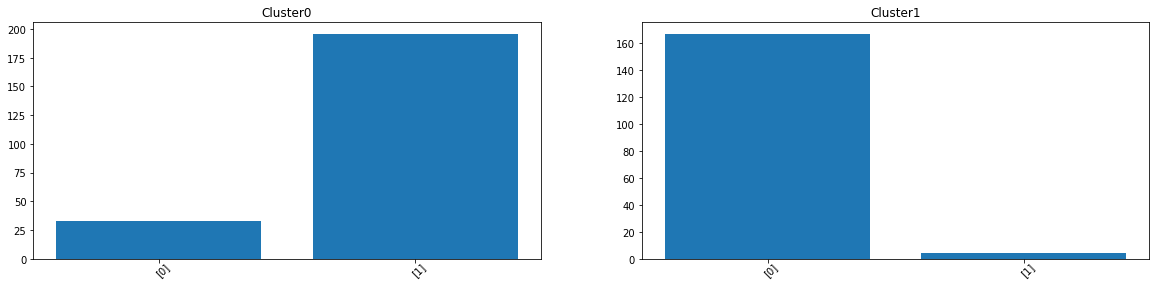

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\4249975297.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


13/13 [==============================] - 1s 43ms/step - loss: 0.2514 - accuracy: 0.4958
Epoch 2/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2500 - accuracy: 0.5066
Epoch 3/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4986
Epoch 4/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2506 - accuracy: 0.4719
Epoch 5/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2504 - accuracy: 0.4966
Epoch 6/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2501 - accuracy: 0.4984
Epoch 7/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2502 - accuracy: 0.4958
Epoch 8/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2505 - accuracy: 0.4739
Epoch 9/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2501 - accuracy: 0.4967
Epoch 10/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4952
Epoch 11/20
13/13 [=

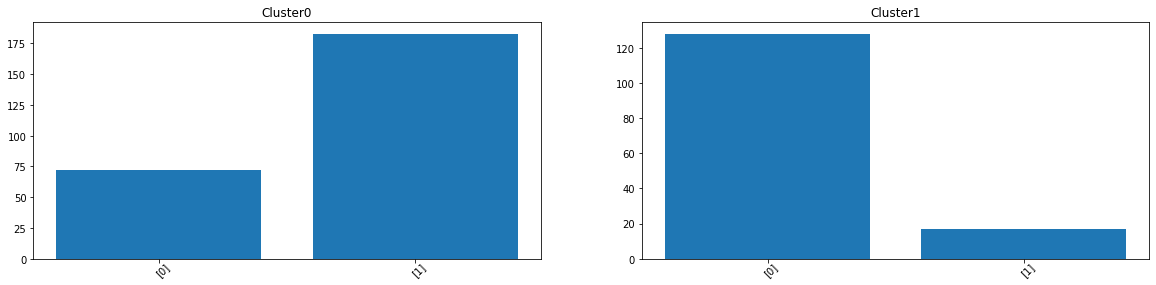

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\4249975297.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


13/13 [==============================] - 1s 51ms/step - loss: 0.2505 - accuracy: 0.4881
Epoch 2/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2517 - accuracy: 0.4753
Epoch 3/20
13/13 [==============================] - 1s 42ms/step - loss: 0.2520 - accuracy: 0.4680
Epoch 4/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2506 - accuracy: 0.4957
Epoch 5/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2507 - accuracy: 0.4914
Epoch 6/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2503 - accuracy: 0.4910
Epoch 7/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2504 - accuracy: 0.4854
Epoch 8/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2503 - accuracy: 0.4971
Epoch 9/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2508 - accuracy: 0.5018
Epoch 10/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2511 - accuracy: 0.4939
Epoch 11/20
13/13 [=

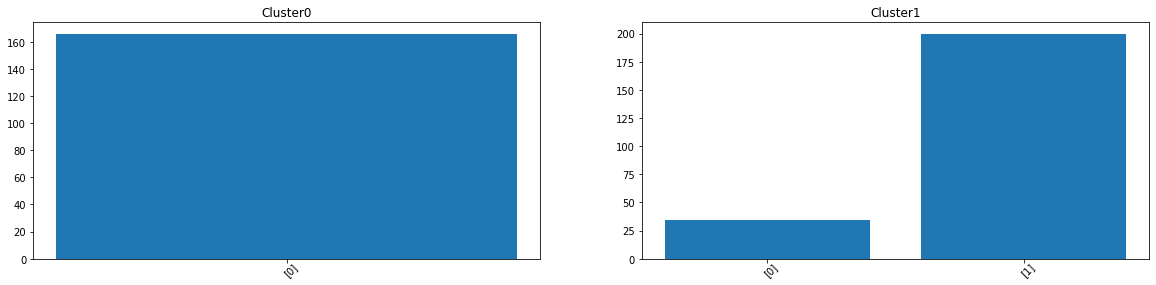

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\4249975297.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


13/13 [==============================] - 1s 43ms/step - loss: 0.2505 - accuracy: 0.4825
Epoch 2/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2503 - accuracy: 0.4884
Epoch 3/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4963
Epoch 4/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2501 - accuracy: 0.5004
Epoch 5/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2503 - accuracy: 0.5001
Epoch 6/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2501 - accuracy: 0.4966
Epoch 7/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2501 - accuracy: 0.4899
Epoch 8/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2501 - accuracy: 0.4938
Epoch 9/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2501 - accuracy: 0.4926
Epoch 10/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2501 - accuracy: 0.4994
Epoch 11/20
13/13 [=

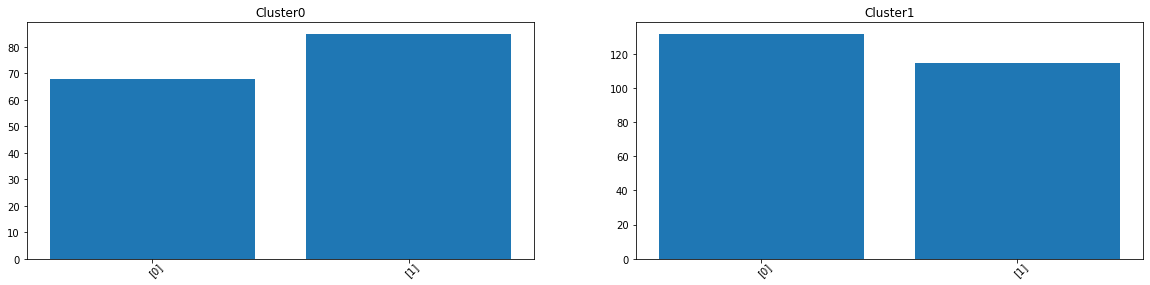

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\4249975297.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


13/13 [==============================] - 1s 43ms/step - loss: 0.2503 - accuracy: 0.4908
Epoch 2/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2503 - accuracy: 0.4867
Epoch 3/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4817
Epoch 4/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2501 - accuracy: 0.4931
Epoch 5/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4843
Epoch 6/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2501 - accuracy: 0.4897
Epoch 7/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2503 - accuracy: 0.4861
Epoch 8/20
13/13 [==============================] - 1s 47ms/step - loss: 0.2501 - accuracy: 0.4923
Epoch 9/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2503 - accuracy: 0.4696
Epoch 10/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2501 - accuracy: 0.4931
Epoch 11/20
13/13 [=

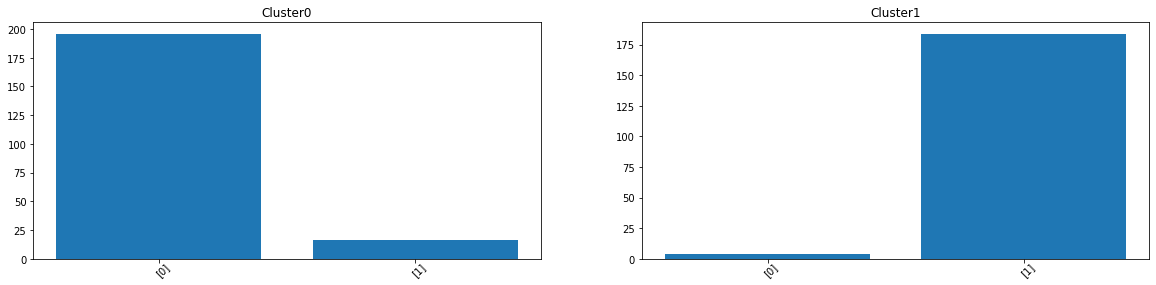

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\4249975297.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


13/13 [==============================] - 1s 44ms/step - loss: 0.2504 - accuracy: 0.4934
Epoch 2/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4969
Epoch 3/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4800
Epoch 4/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4867
Epoch 5/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2502 - accuracy: 0.4971
Epoch 6/20
13/13 [==============================] - 1s 42ms/step - loss: 0.2504 - accuracy: 0.4764
Epoch 7/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4931
Epoch 8/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2501 - accuracy: 0.4876
Epoch 9/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2501 - accuracy: 0.4971
Epoch 10/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2502 - accuracy: 0.4971
Epoch 11/20
13/13 [=

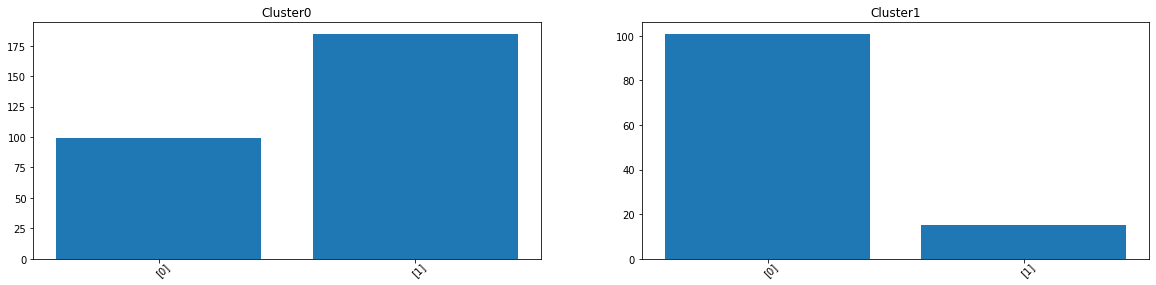

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\4249975297.py:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


7/7 [==============================] - 1s 40ms/step - loss: 0.2271 - accuracy: 0.9397
Epoch 2/20
7/7 [==============================] - 0s 41ms/step - loss: 0.1510 - accuracy: 1.0000
Epoch 3/20
7/7 [==============================] - 0s 45ms/step - loss: 0.0441 - accuracy: 1.0000
Epoch 4/20
7/7 [==============================] - 0s 40ms/step - loss: 0.0134 - accuracy: 1.0000
Epoch 5/20
7/7 [==============================] - 0s 41ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 6/20
7/7 [==============================] - 0s 41ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 7/20
7/7 [==============================] - 0s 40ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 8/20
7/7 [==============================] - 0s 40ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 9/20
7/7 [==============================] - 0s 40ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 10/20
7/7 [==============================] - 0s 40ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 11/20
7/7 [=======================

IndexError: list index out of range

In [43]:
for tx, lb in zip(txt, dt):
        
    df_merged, df_end = get_label(tx,lb)
    # Change the name
    frame = df_merged 
    frame.label = pd.np.where(frame.label == 'POSITION-UPRIGHT' ,' Aufrecht', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-SUPINE' ,' Rücken', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-LEFT' ,' Links', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-RIGHT',' Rechts', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-UNKNOWN',' A', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-PRONE',' Bauch', frame.label)
    frame.label = pd.np.where(frame.label == 0,' Zeros', frame.label)
    frame.label = pd.np.where(frame.label != ' Rücken',' Not Rücken', frame.label)
    df_merged = frame
    # Bring number of sample
    num_img = 200
    counts_col = df_merged.groupby("label")["label"].transform(len)
    mask = (counts_col > int(num_img)) 
    df_merged = df_merged[mask]
    sample = df_merged.groupby('label').sample(n=int(num_img),random_state=2).reset_index().drop(columns=['index'])
    sample.label.unique()
    sample.label = pd.np.where(sample.label == 0,' Zeros', sample.label)
    sample.label = sample.label.astype('category')
    sample.label = sample.label.cat.codes
    
    collect = []
    for i in range(len(sample.pressure)):

        img = sample.pressure[i]
        img = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
        reshaped_img = img.reshape(48, 48, 1)
        collect.append(reshaped_img)

    collect = np.array(collect)
    y = sample.label

    def generate_data(X_train, y_train):

        data = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1)  
        data.fit(X_train)
        data_generator = data.flow(X_train,y_train)
        return data_generator

    data_from_generator = generate_data(collect,y)
    optimizer = keras.optimizers.Adam()
    loss = keras.losses.mean_squared_error
    model.compile(optimizer=optimizer, loss= loss, metrics=["accuracy"])
    model.fit_generator(data_from_generator,epochs = 20)
    mm = keras.Model(inputs=model.input, outputs=model.output)
    if tx[-10:-4]=='Events':
        model.save(f"{tx[-18:-4]}.h5")
    else:
        model.save(f"{tx[-22:-4]}.h5")
  
    embdedded_model = keras.Model(inputs=model.input, outputs=model.get_layer(name="embedding").output)
    embdedded_model.summary()
    features = embdedded_model.predict(collect)
    Clus_dataSet =features
    y_train = y
    y = y_train
    print(y.unique())
    #n_clusters = number of unique value because INDEX has 10 values. Not the best value but a simple logic.
    #The value of n_init at 30 yields good results so we will use it. For confirmation us the above code.
    k_means = KMeans(init = "k-means++", n_clusters = y.nunique(), n_init = 30)
    #fit the data to our k_means model
    k_means.fit(Clus_dataSet)


    k_means_labels = k_means.labels_ #List of labels of each dataset
    print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))
    G = len(np.unique(k_means_labels)) #Number of labels

    #2D matrix  for an array of indexes of the given label
    cluster_index= [[] for i in range(G)]
    for i, label in enumerate(k_means_labels,0):
        for n in range(G):
            if label == n:
                cluster_index[n].append(i)
            else:
                continue  

    # # #Visualisation for clusters = clust
    # plt.figure(figsize=(20,20));
    # clust = y.nunique() #enter label number to visualise
    # num = 100 #num of data to visualize from the cluster
    # for i in range(1,num): 
    #     plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
    #     plt.imshow(X[cluster_index[clust][i+1]].reshape(X_train.shape[1], X_train.shape[2]), cmap = plt.cm.binary);
        
    # plt.show()

    Y_clust = [[] for i in range(G)]
    for n in range(G):
        Y_clust[n] = y[cluster_index[n]] #Y_clust[0] contains array of "correct" category from y_train for the cluster_index[0]
        assert(len(Y_clust[n]) == len(cluster_index[n])) #dimension confirmation

    #counts the number of each category in each cluster
    def counter(cluster):
        unique, counts = np.unique(cluster, return_counts=True)
        label_index = dict(zip(unique, counts))
        return label_index

    label_count= [[] for i in range(G)]
    for n in range(G):
        label_count[n] = counter(Y_clust[n])

    label_count[1] #Number of items of a certain category in cluster 1
    #A function to plot a bar graph for visualising the number of items of certain category in a cluster
    def plotter(label_dict):
        plt.bar(range(len(label_dict)), list(label_dict.values()), align='center')
        a = []
        for i in [*label_dict]: a.append([i])
        plt.xticks(range(len(label_dict)), list(a), rotation=45, rotation_mode='anchor')
    #Bar graph with the number of items of different categories clustered in it
    plt.figure(figsize=(20,20))
    for i in range (1,(y.nunique())+1):
        plt.subplot(4, 2, i)
        plotter(label_count[i-1]) 
        plt.title("Cluster" + str(i-1))
    plt.show()

Data Augmentation -> Feature Extraction -> KMeans

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


19/19 [==============================] - 2s 78ms/step - loss: 0.8299 - accuracy: 0.3333
Epoch 2/20
19/19 [==============================] - 1s 78ms/step - loss: 0.6904 - accuracy: 0.3333
Epoch 3/20
19/19 [==============================] - 1s 76ms/step - loss: 0.6688 - accuracy: 0.3333
Epoch 4/20
19/19 [==============================] - 1s 77ms/step - loss: 0.6695 - accuracy: 0.3333
Epoch 5/20
19/19 [==============================] - 2s 80ms/step - loss: 0.6678 - accuracy: 0.3333
Epoch 6/20
19/19 [==============================] - 1s 76ms/step - loss: 0.6683 - accuracy: 0.3333
Epoch 7/20
19/19 [==============================] - 1s 74ms/step - loss: 0.6702 - accuracy: 0.3333
Epoch 8/20
19/19 [==============================] - 1s 77ms/step - loss: 0.6774 - accuracy: 0.3333
Epoch 9/20
19/19 [==============================] - 1s 77ms/step - loss: 0.6736 - accuracy: 0.3333
Epoch 10/20
19/19 [==============================] - 1s 76ms/step - loss: 0.6683 - accuracy: 0.3333
Epoch 11/20
19/19 [=

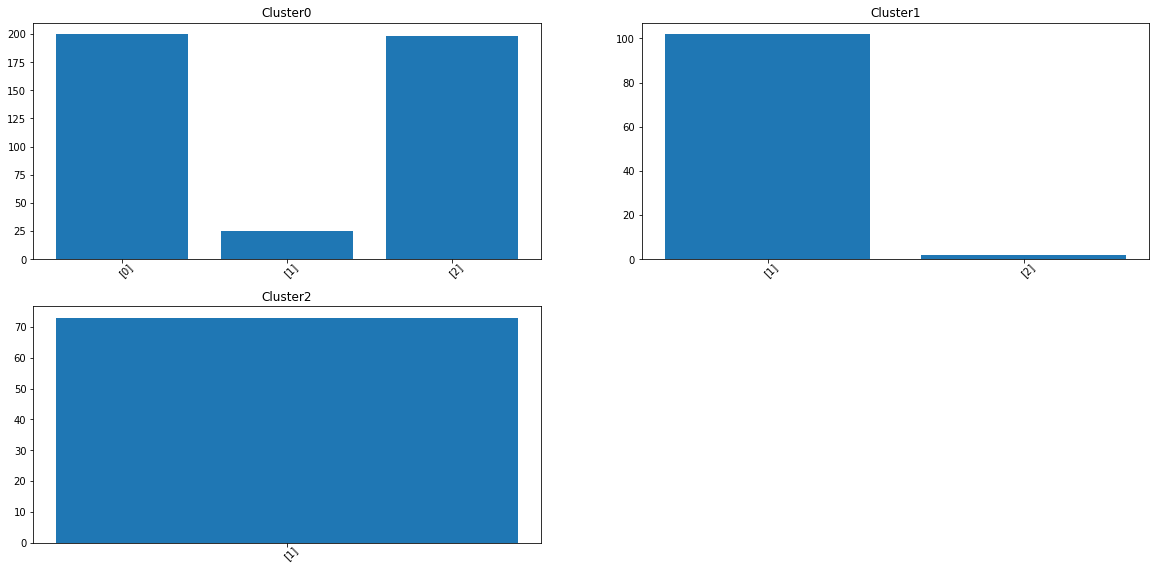

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


32/32 [==============================] - 2s 43ms/step - loss: 2.2396 - accuracy: 0.2000
Epoch 2/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0149 - accuracy: 0.2000
Epoch 3/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0161 - accuracy: 0.2000
Epoch 4/20
32/32 [==============================] - 1s 45ms/step - loss: 2.0081 - accuracy: 0.2000
Epoch 5/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0122 - accuracy: 0.2000
Epoch 6/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0193 - accuracy: 0.2000
Epoch 7/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0059 - accuracy: 0.2000
Epoch 8/20
32/32 [==============================] - 1s 44ms/step - loss: 1.9946 - accuracy: 0.2000
Epoch 9/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0205 - accuracy: 0.2000
Epoch 10/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0095 - accuracy: 0.2000
Epoch 11/20
32/32 [=

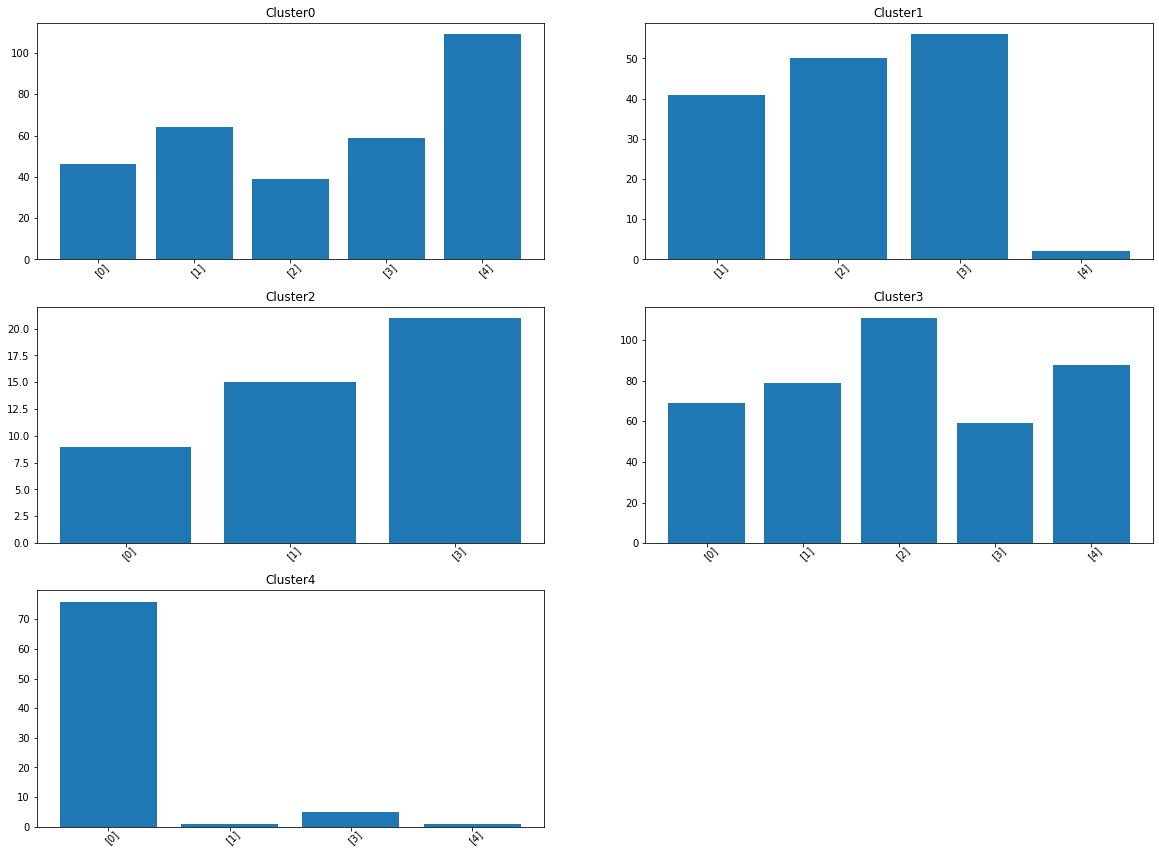

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


32/32 [==============================] - 2s 44ms/step - loss: 2.0050 - accuracy: 0.2000
Epoch 2/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0231 - accuracy: 0.2000
Epoch 3/20
32/32 [==============================] - 1s 45ms/step - loss: 2.0079 - accuracy: 0.2000
Epoch 4/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0142 - accuracy: 0.2000
Epoch 5/20
32/32 [==============================] - 1s 43ms/step - loss: 2.0177 - accuracy: 0.2000
Epoch 6/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0078 - accuracy: 0.2000
Epoch 7/20
32/32 [==============================] - 1s 43ms/step - loss: 2.0276 - accuracy: 0.2000
Epoch 8/20
32/32 [==============================] - 1s 43ms/step - loss: 2.0323 - accuracy: 0.2000
Epoch 9/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0240 - accuracy: 0.2000
Epoch 10/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0050 - accuracy: 0.2000
Epoch 11/20
32/32 [=

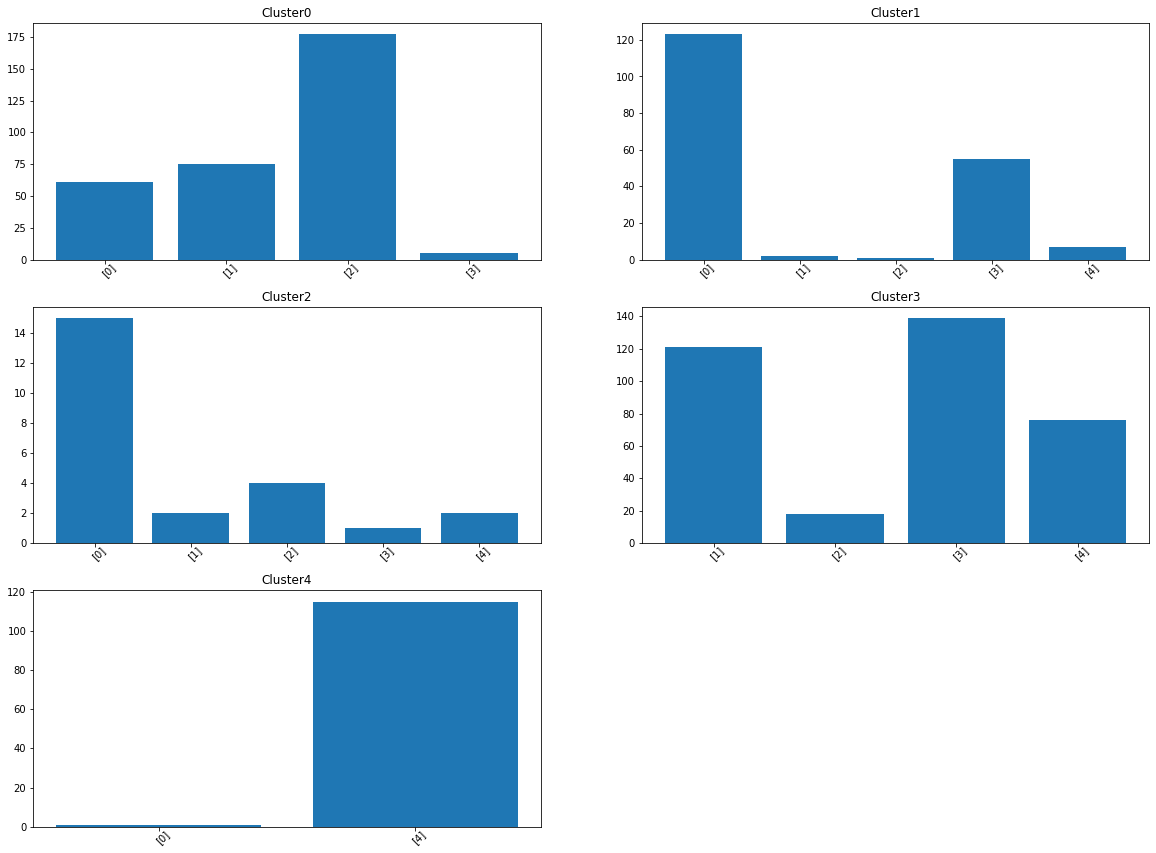

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


25/25 [==============================] - 2s 44ms/step - loss: 1.2856 - accuracy: 0.2500
Epoch 2/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2584 - accuracy: 0.2500
Epoch 3/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2528 - accuracy: 0.2500
Epoch 4/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2648 - accuracy: 0.2500
Epoch 5/20
25/25 [==============================] - 1s 46ms/step - loss: 1.2563 - accuracy: 0.2500
Epoch 6/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2546 - accuracy: 0.2500
Epoch 7/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2512 - accuracy: 0.2500
Epoch 8/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2550 - accuracy: 0.2500
Epoch 9/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2574 - accuracy: 0.2500
Epoch 10/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2606 - accuracy: 0.2500
Epoch 11/20
25/25 [=

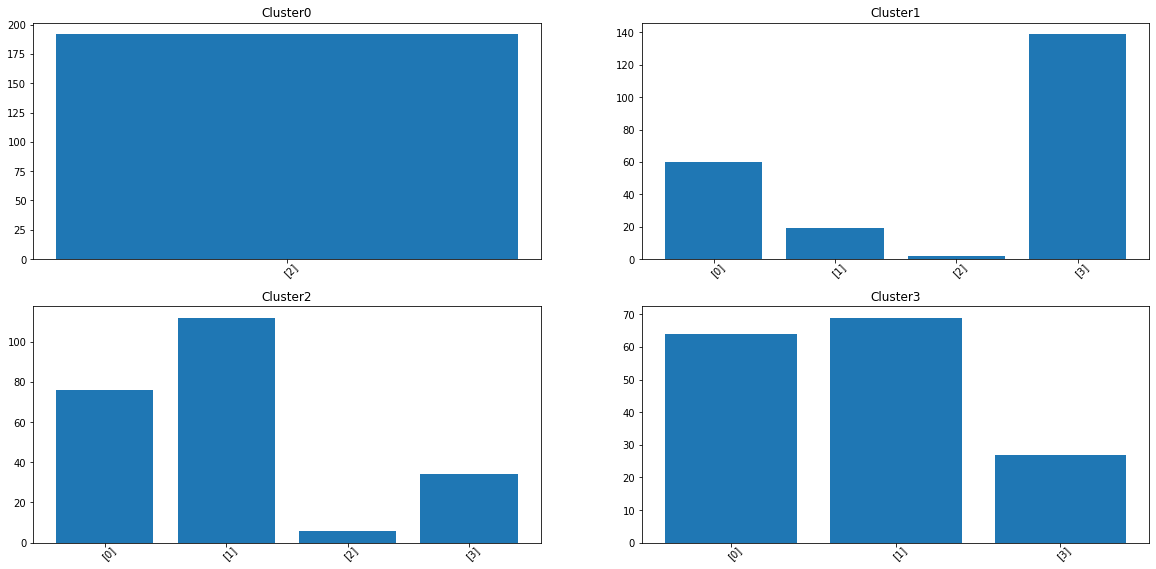

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


19/19 [==============================] - 1s 49ms/step - loss: 0.7452 - accuracy: 0.3333
Epoch 2/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6726 - accuracy: 0.3333
Epoch 3/20
19/19 [==============================] - 1s 45ms/step - loss: 0.6664 - accuracy: 0.3333
Epoch 4/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6689 - accuracy: 0.3333
Epoch 5/20
19/19 [==============================] - 1s 45ms/step - loss: 0.6673 - accuracy: 0.3333
Epoch 6/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6690 - accuracy: 0.3333
Epoch 7/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6697 - accuracy: 0.3333
Epoch 8/20
19/19 [==============================] - 1s 43ms/step - loss: 0.6686 - accuracy: 0.3333
Epoch 9/20
19/19 [==============================] - 1s 43ms/step - loss: 0.6713 - accuracy: 0.3333
Epoch 10/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6685 - accuracy: 0.3333
Epoch 11/20
19/19 [=

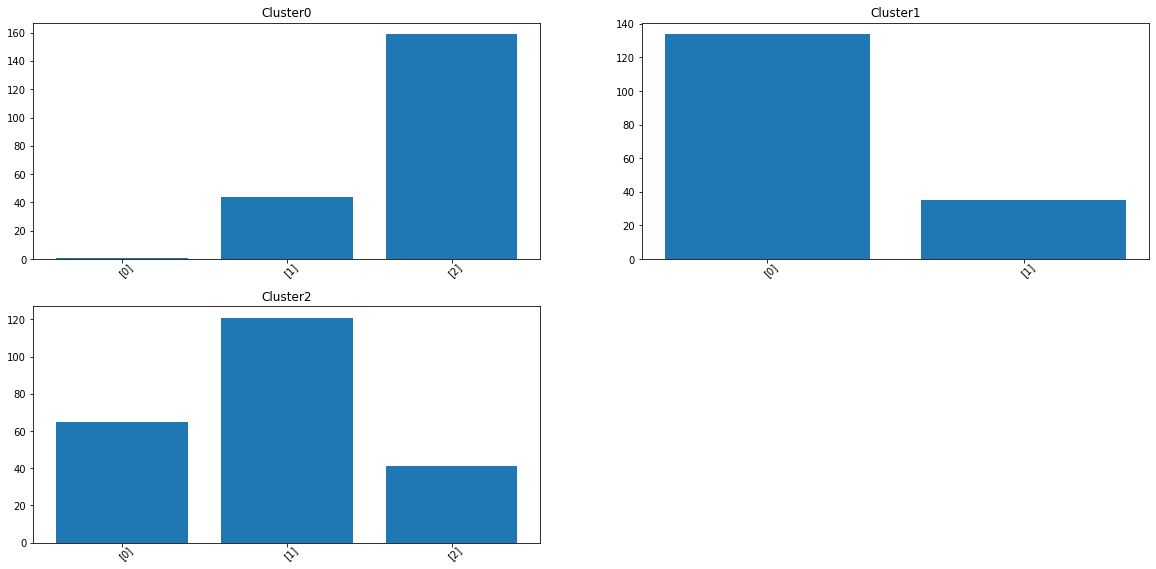

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


13/13 [==============================] - 1s 44ms/step - loss: 0.3398 - accuracy: 0.5000
Epoch 2/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2553 - accuracy: 0.4972
Epoch 3/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2530 - accuracy: 0.4998
Epoch 4/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2518 - accuracy: 0.4993
Epoch 5/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2507 - accuracy: 0.4982
Epoch 6/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2505 - accuracy: 0.4913
Epoch 7/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2502 - accuracy: 0.4968
Epoch 8/20
13/13 [==============================] - 1s 42ms/step - loss: 0.2504 - accuracy: 0.4898
Epoch 9/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2505 - accuracy: 0.4955
Epoch 10/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2516 - accuracy: 0.4564
Epoch 11/20
13/13 [=

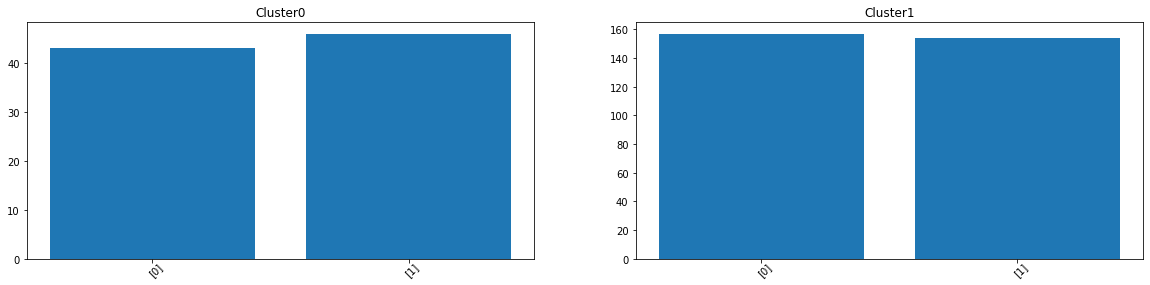

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


32/32 [==============================] - 2s 44ms/step - loss: 3.0732 - accuracy: 0.1980
Epoch 2/20
32/32 [==============================] - 1s 43ms/step - loss: 2.0591 - accuracy: 0.2000
Epoch 3/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0198 - accuracy: 0.2000
Epoch 4/20
32/32 [==============================] - 1s 43ms/step - loss: 2.0102 - accuracy: 0.2000
Epoch 5/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0097 - accuracy: 0.2000
Epoch 6/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0193 - accuracy: 0.2000
Epoch 7/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0093 - accuracy: 0.2000
Epoch 8/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0102 - accuracy: 0.2000
Epoch 9/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0046 - accuracy: 0.2000
Epoch 10/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0059 - accuracy: 0.2000
Epoch 11/20
32/32 [=

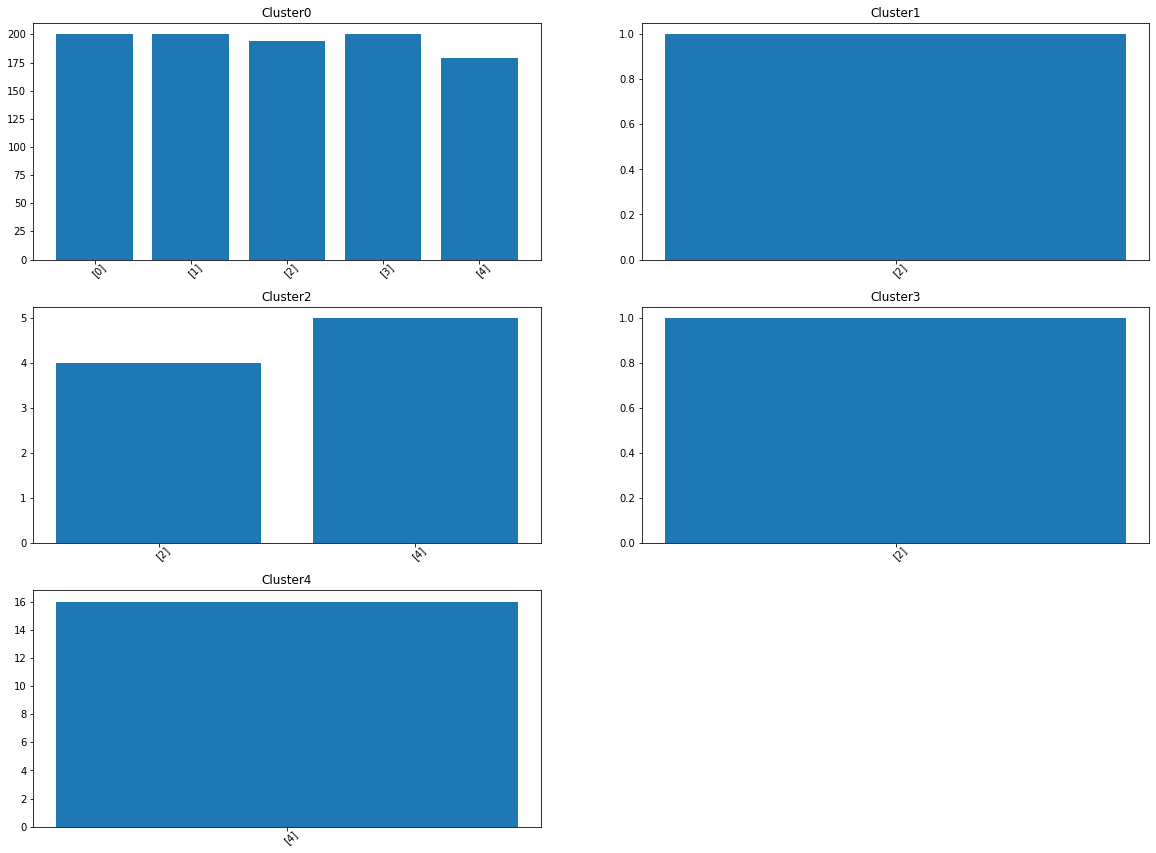

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


25/25 [==============================] - 2s 46ms/step - loss: 1.3099 - accuracy: 0.2500
Epoch 2/20
25/25 [==============================] - 1s 44ms/step - loss: 1.2571 - accuracy: 0.2500
Epoch 3/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2532 - accuracy: 0.2500
Epoch 4/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2601 - accuracy: 0.2500
Epoch 5/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2588 - accuracy: 0.2500
Epoch 6/20
25/25 [==============================] - 1s 44ms/step - loss: 1.2546 - accuracy: 0.2500
Epoch 7/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2562 - accuracy: 0.2500
Epoch 8/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2548 - accuracy: 0.2500
Epoch 9/20
25/25 [==============================] - 1s 44ms/step - loss: 1.2543 - accuracy: 0.2500
Epoch 10/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2521 - accuracy: 0.2500
Epoch 11/20
25/25 [=

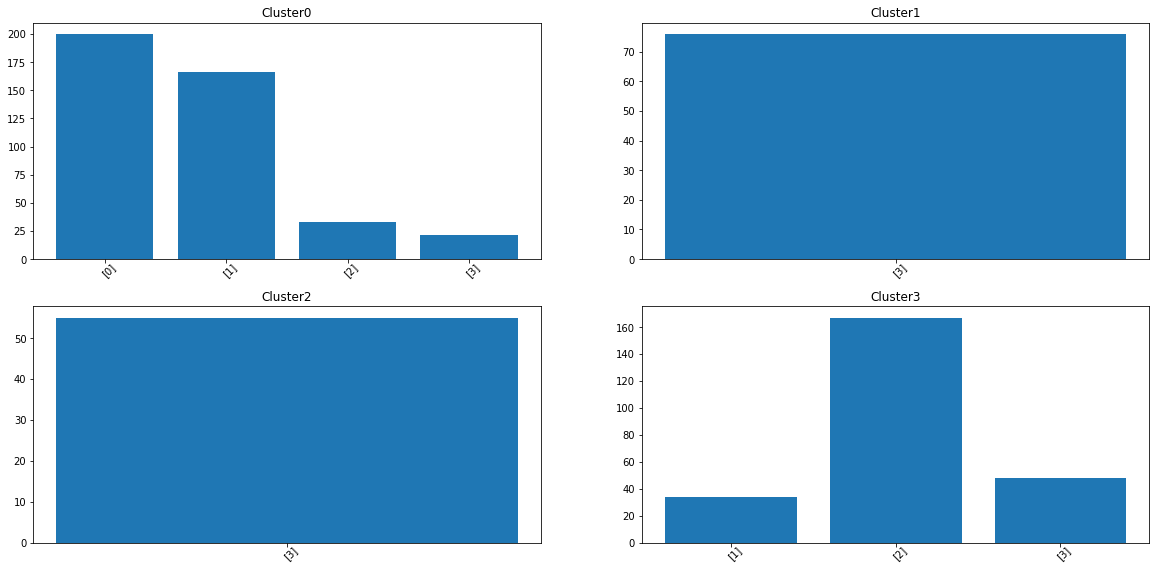

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


13/13 [==============================] - 1s 43ms/step - loss: 0.7285 - accuracy: 0.5000
Epoch 2/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2814 - accuracy: 0.5087
Epoch 3/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2576 - accuracy: 0.4921
Epoch 4/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2539 - accuracy: 0.4909
Epoch 5/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2513 - accuracy: 0.5023
Epoch 6/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2511 - accuracy: 0.4998
Epoch 7/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2509 - accuracy: 0.4990
Epoch 8/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2506 - accuracy: 0.5007
Epoch 9/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2504 - accuracy: 0.5018
Epoch 10/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2520 - accuracy: 0.4811
Epoch 11/20
13/13 [=

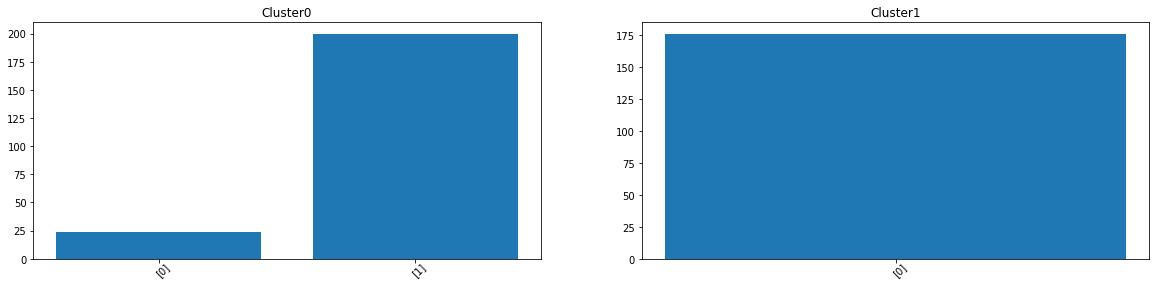

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


19/19 [==============================] - 1s 44ms/step - loss: 0.7243 - accuracy: 0.3303
Epoch 2/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6808 - accuracy: 0.3333
Epoch 3/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6783 - accuracy: 0.3333
Epoch 4/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6705 - accuracy: 0.3333
Epoch 5/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6719 - accuracy: 0.3333
Epoch 6/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6692 - accuracy: 0.3333
Epoch 7/20
19/19 [==============================] - 1s 45ms/step - loss: 0.6710 - accuracy: 0.3333
Epoch 8/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6701 - accuracy: 0.3333
Epoch 9/20
19/19 [==============================] - 1s 45ms/step - loss: 0.6751 - accuracy: 0.3333
Epoch 10/20
19/19 [==============================] - 1s 44ms/step - loss: 0.6788 - accuracy: 0.3333
Epoch 11/20
19/19 [=

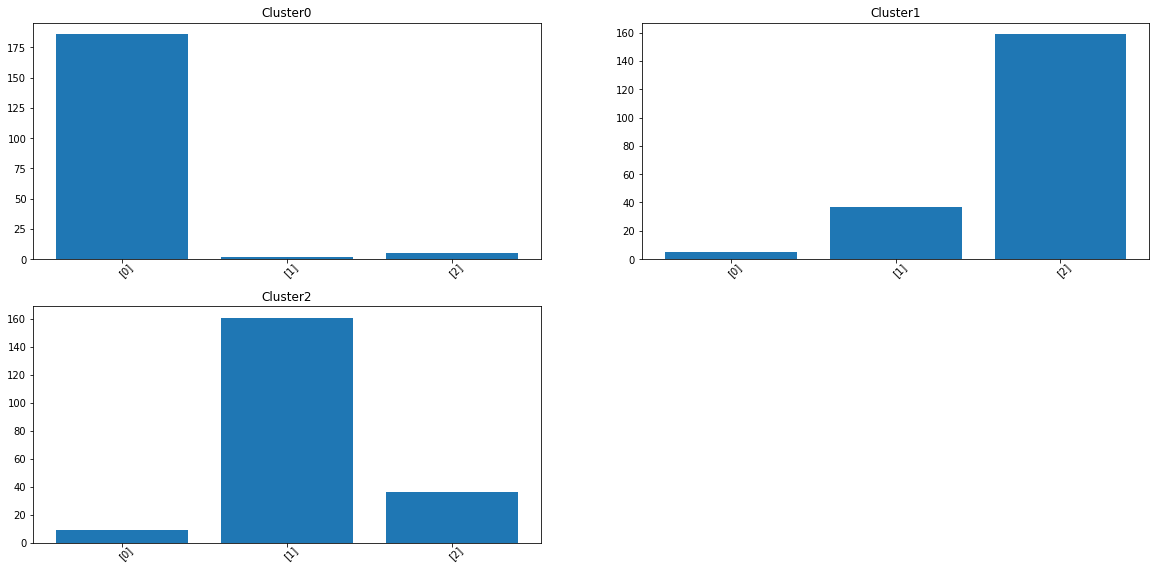

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


25/25 [==============================] - 2s 44ms/step - loss: 1.3228 - accuracy: 0.2500
Epoch 2/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2533 - accuracy: 0.2500
Epoch 3/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2542 - accuracy: 0.2500
Epoch 4/20
25/25 [==============================] - 1s 46ms/step - loss: 1.2551 - accuracy: 0.2500
Epoch 5/20
25/25 [==============================] - 1s 47ms/step - loss: 1.2582 - accuracy: 0.2500
Epoch 6/20
25/25 [==============================] - 1s 46ms/step - loss: 1.2535 - accuracy: 0.2500
Epoch 7/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2583 - accuracy: 0.2500
Epoch 8/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2583 - accuracy: 0.2500
Epoch 9/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2558 - accuracy: 0.2500
Epoch 10/20
25/25 [==============================] - 1s 45ms/step - loss: 1.2555 - accuracy: 0.2500
Epoch 11/20
25/25 [=

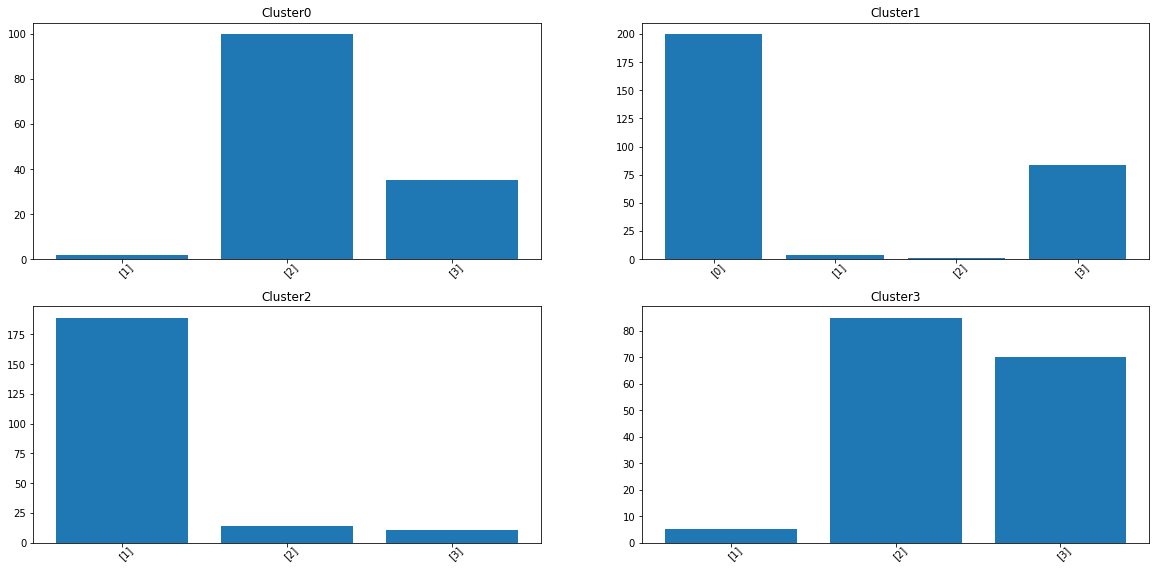

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


13/13 [==============================] - 1s 43ms/step - loss: 0.7129 - accuracy: 0.5000
Epoch 2/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2891 - accuracy: 0.4924
Epoch 3/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2539 - accuracy: 0.5040
Epoch 4/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2526 - accuracy: 0.5007
Epoch 5/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2532 - accuracy: 0.4819
Epoch 6/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2509 - accuracy: 0.4994
Epoch 7/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2515 - accuracy: 0.4932
Epoch 8/20
13/13 [==============================] - 1s 44ms/step - loss: 0.2512 - accuracy: 0.4888
Epoch 9/20
13/13 [==============================] - 1s 45ms/step - loss: 0.2505 - accuracy: 0.4995
Epoch 10/20
13/13 [==============================] - 1s 43ms/step - loss: 0.2515 - accuracy: 0.4806
Epoch 11/20
13/13 [=

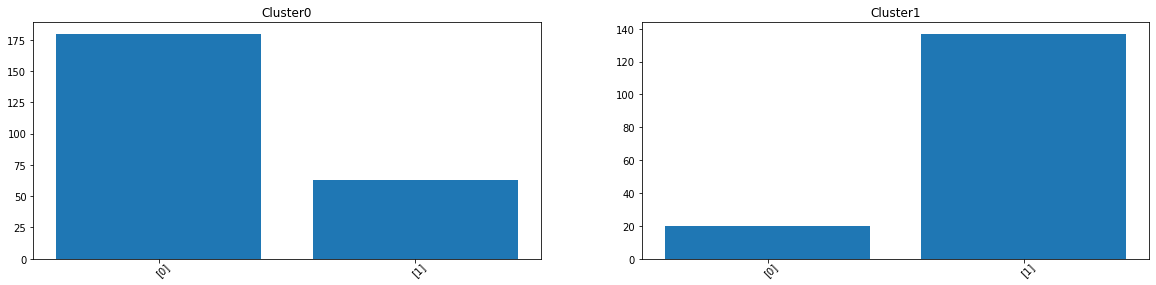

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\1403657002.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


32/32 [==============================] - 2s 45ms/step - loss: 2.8247 - accuracy: 0.2012
Epoch 2/20
32/32 [==============================] - 1s 45ms/step - loss: 2.0209 - accuracy: 0.2000
Epoch 3/20
32/32 [==============================] - 1s 45ms/step - loss: 2.0090 - accuracy: 0.2000
Epoch 4/20
32/32 [==============================] - 2s 47ms/step - loss: 2.0079 - accuracy: 0.2000
Epoch 5/20
32/32 [==============================] - 1s 46ms/step - loss: 2.0110 - accuracy: 0.2000
Epoch 6/20
32/32 [==============================] - 1s 45ms/step - loss: 2.0153 - accuracy: 0.2000
Epoch 7/20
32/32 [==============================] - 1s 45ms/step - loss: 2.0203 - accuracy: 0.2000
Epoch 8/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0179 - accuracy: 0.2000
Epoch 9/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0138 - accuracy: 0.2000
Epoch 10/20
32/32 [==============================] - 1s 44ms/step - loss: 2.0047 - accuracy: 0.2000
Epoch 11/20
32/32 [=

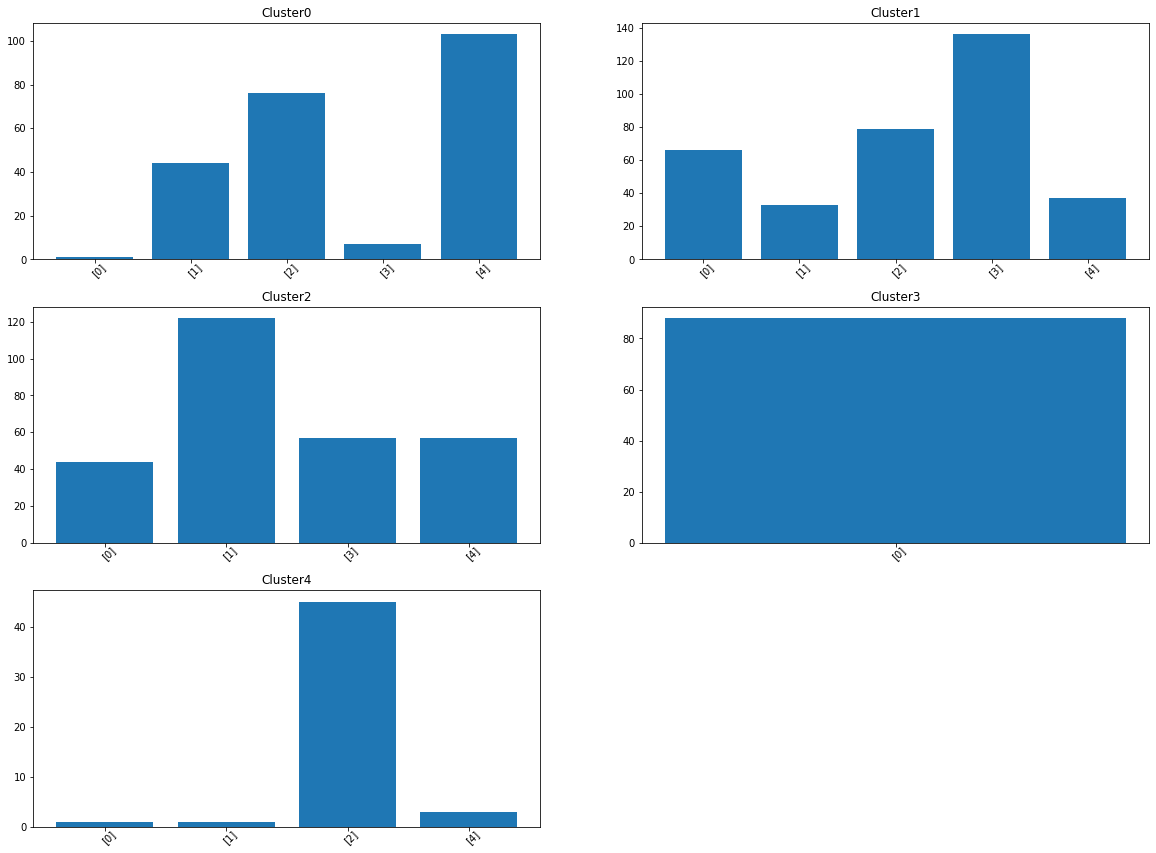

ValueError: need at least one array to concatenate

In [42]:
for tx, lb in zip(txt, dt):
        
    df_merged, df_end = get_label(tx,lb)
    # Change the name
    frame = df_merged 
    frame.label = pd.np.where(frame.label == 'POSITION-UPRIGHT' ,' Aufrecht', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-SUPINE' ,' Rücken', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-LEFT' ,' Links', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-RIGHT',' Rechts', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-UNKNOWN',' A', frame.label)
    frame.label = pd.np.where(frame.label == 'POSITION-PRONE',' Bauch', frame.label)
    frame.label = pd.np.where(frame.label == 0,' Zeros', frame.label)
    df_merged = frame
    # Bring number of sample
    num_img = 200
    counts_col = df_merged.groupby("label")["label"].transform(len)
    mask = (counts_col > int(num_img)) 
    df_merged = df_merged[mask]
    sample = df_merged.groupby('label').sample(n=int(num_img),random_state=2).reset_index().drop(columns=['index'])
    sample.label.unique()
    sample.label = pd.np.where(sample.label == 0,' Zeros', sample.label)
    sample.label = sample.label.astype('category')
    sample.label = sample.label.cat.codes
    
    collect = []
    for i in range(len(sample.pressure)):

        img = sample.pressure[i]
        img = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
        reshaped_img = img.reshape(48, 48, 1)
        collect.append(reshaped_img)

    collect = np.array(collect)
    y = sample.label

    def generate_data(X_train, y_train):

        data = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1)  
        data.fit(X_train)
        data_generator = data.flow(X_train,y_train)
        return data_generator

    data_from_generator = generate_data(collect,y)
    optimizer = keras.optimizers.Adam()
    loss = keras.losses.mean_squared_error
    model.compile(optimizer=optimizer, loss= loss, metrics=["accuracy"])
    model.fit_generator(data_from_generator,epochs = 20)
    mm = keras.Model(inputs=model.input, outputs=model.output)
    if tx[-10:-4]=='Events':
        model.save(f"{tx[-18:-4]}.h5")
    else:
        model.save(f"{tx[-22:-4]}.h5")
  
    embdedded_model = keras.Model(inputs=model.input, outputs=model.get_layer(name="embedding").output)
    embdedded_model.summary()
    features = embdedded_model.predict(collect)
    Clus_dataSet =features
    y_train = y
    y = y_train
    print(y.unique())
    #n_clusters = number of unique value because INDEX has 10 values. Not the best value but a simple logic.
    #The value of n_init at 30 yields good results so we will use it. For confirmation us the above code.
    k_means = KMeans(init = "k-means++", n_clusters = y.nunique(), n_init = 30)
    #fit the data to our k_means model
    k_means.fit(Clus_dataSet)


    k_means_labels = k_means.labels_ #List of labels of each dataset
    print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))
    G = len(np.unique(k_means_labels)) #Number of labels

    #2D matrix  for an array of indexes of the given label
    cluster_index= [[] for i in range(G)]
    for i, label in enumerate(k_means_labels,0):
        for n in range(G):
            if label == n:
                cluster_index[n].append(i)
            else:
                continue  

    # # #Visualisation for clusters = clust
    # plt.figure(figsize=(20,20));
    # clust = y.nunique() #enter label number to visualise
    # num = 100 #num of data to visualize from the cluster
    # for i in range(1,num): 
    #     plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
    #     plt.imshow(X[cluster_index[clust][i+1]].reshape(X_train.shape[1], X_train.shape[2]), cmap = plt.cm.binary);
        
    # plt.show()

    Y_clust = [[] for i in range(G)]
    for n in range(G):
        Y_clust[n] = y[cluster_index[n]] #Y_clust[0] contains array of "correct" category from y_train for the cluster_index[0]
        assert(len(Y_clust[n]) == len(cluster_index[n])) #dimension confirmation

    #counts the number of each category in each cluster
    def counter(cluster):
        unique, counts = np.unique(cluster, return_counts=True)
        label_index = dict(zip(unique, counts))
        return label_index

    label_count= [[] for i in range(G)]
    for n in range(G):
        label_count[n] = counter(Y_clust[n])

    label_count[1] #Number of items of a certain category in cluster 1
    #A function to plot a bar graph for visualising the number of items of certain category in a cluster
    def plotter(label_dict):
        plt.bar(range(len(label_dict)), list(label_dict.values()), align='center')
        a = []
        for i in [*label_dict]: a.append([i])
        plt.xticks(range(len(label_dict)), list(a), rotation=45, rotation_mode='anchor')
    #Bar graph with the number of items of different categories clustered in it
    plt.figure(figsize=(20,20))
    for i in range (1,(y.nunique())+1):
        plt.subplot(4, 2, i)
        plotter(label_count[i-1]) 
        plt.title("Cluster" + str(i-1))
    plt.show()

In [10]:
df_merged, df_end = get_label(txt[0],dt[0])

In [11]:
# Bring number of sample
num_img = 200
counts_col = df_merged.groupby("label")["label"].transform(len)
mask = (counts_col > int(num_img)) 
df_merged = df_merged[mask]
sample = df_merged.groupby('label').sample(n=int(num_img),random_state=2).reset_index().drop(columns=['index'])

In [13]:
sample.label.unique()

array([0, 'POSITION-SUPINE', 'POSITION-UNKNOWN'], dtype=object)

In [14]:
sample.label = pd.np.where(sample.label == 0,' Zeros', sample.label)

In [15]:
sample.label = sample.label.astype('category')

In [16]:
sample.label = sample.label.cat.codes

In [17]:
sample.pressure[0].shape

(48, 22)

CNN

In [18]:
from tensorflow import keras
import tensorflow as tf
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

In [19]:
def CAE(input_shape=(48, 48, 1), filters=[32, 64, 128, 10]):
    model = keras.Sequential()
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    model.add(layers.Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape))

    model.add(layers.Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2'))

    model.add(layers.Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3'))

    model.add(layers.Flatten())
    model.add(layers.Dense(units=filters[3], name='embedding'))
    model.add(layers.Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu'))

    model.add(layers.Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2])))
    model.add(layers.Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3'))

    model.add(layers.Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2'))

    model.add(layers.Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1'))
    model.summary()
    return model

In [20]:
model = CAE()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 24, 24, 32)        832       
                                                                 
 conv2 (Conv2D)              (None, 12, 12, 64)        51264     
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 embedding (Dense)           (None, 10)                46090     
                                                                 
 dense (Dense)               (None, 4608)              50688     
                                                                 
 reshape (Reshape)           (None, 6, 6, 128)         0

In [ ]:
collect = []
for i in range(len(sample.pressure)):

    img = sample.pressure[i]
    img = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
    reshaped_img = img.reshape(48, 48, 1)
    collect.append(reshaped_img)

collect = np.array(collect)
y = sample.label

def generate_data(X_train, y_train):

    data = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1)  
    data.fit(X_train)
    data_generator = data.flow(X_train,y_train)
    return data_generator

data_from_generator = generate_data(collect,y)
optimizer = keras.optimizers.Adam()
loss = keras.losses.mean_squared_error
model.compile(optimizer=optimizer, loss= loss, metrics=["accuracy"])
model.fit_generator(data_from_generator,epochs = 20)
mm = keras.Model(inputs=model.input, outputs=model.output)
model.save("Autoencoder_patient.h5")



In [21]:
collect = []
for i in range(len(sample.pressure)):

    img = sample.pressure[i]
    img = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
    reshaped_img = img.reshape(48, 48, 1)
    collect.append(reshaped_img)

In [22]:
collect = np.array(collect)

In [23]:
y = sample.label

In [24]:
def generate_data(X_train, y_train):

    data = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1)  
    data.fit(X_train)
    data_generator = data.flow(X_train,y_train)
    return data_generator

In [25]:
data_from_generator = generate_data(collect,y)

In [26]:
optimizer = keras.optimizers.Adam()
loss = keras.losses.mean_squared_error
model.compile(optimizer=optimizer, loss= loss, metrics=["accuracy"])

In [27]:
model.fit_generator(data_from_generator,epochs = 20)

Epoch 1/20


C:\Users\phili\AppData\Local\Temp\ipykernel_21868\2874452368.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(data_from_generator,epochs = 20)


19/19 [==============================] - 2s 53ms/step - loss: 1.7391 - accuracy: 0.3373
Epoch 2/20
19/19 [==============================] - 1s 53ms/step - loss: 1.1560 - accuracy: 0.3264
Epoch 3/20
19/19 [==============================] - 1s 52ms/step - loss: 0.7712 - accuracy: 0.3317
Epoch 4/20
19/19 [==============================] - 1s 52ms/step - loss: 0.7068 - accuracy: 0.3340
Epoch 5/20
19/19 [==============================] - 1s 53ms/step - loss: 0.7043 - accuracy: 0.3331
Epoch 6/20
19/19 [==============================] - 1s 47ms/step - loss: 0.7195 - accuracy: 0.3330
Epoch 7/20
19/19 [==============================] - 1s 47ms/step - loss: 0.7504 - accuracy: 0.3333
Epoch 8/20
19/19 [==============================] - 1s 48ms/step - loss: 0.6891 - accuracy: 0.3333
Epoch 9/20
19/19 [==============================] - 1s 48ms/step - loss: 0.7178 - accuracy: 0.3331
Epoch 10/20
19/19 [==============================] - 1s 50ms/step - loss: 0.6911 - accuracy: 0.3338
Epoch 11/20
19/19 [=

In [28]:
mm = keras.Model(inputs=model.input, outputs=model.output)
mm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_input (InputLayer)    [(None, 48, 48, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        832       
                                                                 
 conv2 (Conv2D)              (None, 12, 12, 64)        51264     
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 embedding (Dense)           (None, 10)                46090     
                                                                 
 dense (Dense)               (None, 4608)              50688 

In [29]:
model.save("Autoencoder_patient.h5")

In [30]:
embdedded_model = keras.Model(inputs=model.input, outputs=model.get_layer(name="embedding").output)
embdedded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_input (InputLayer)    [(None, 48, 48, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        832       
                                                                 
 conv2 (Conv2D)              (None, 12, 12, 64)        51264     
                                                                 
 conv3 (Conv2D)              (None, 6, 6, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 embedding (Dense)           (None, 10)                46090     
                                                                 
Total params: 172,042
Trainable params: 172,042
Non-trainab

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [31]:
features = embdedded_model.predict(collect)

[0 1 2]
The list of labels of the clusters are [0 1 2]


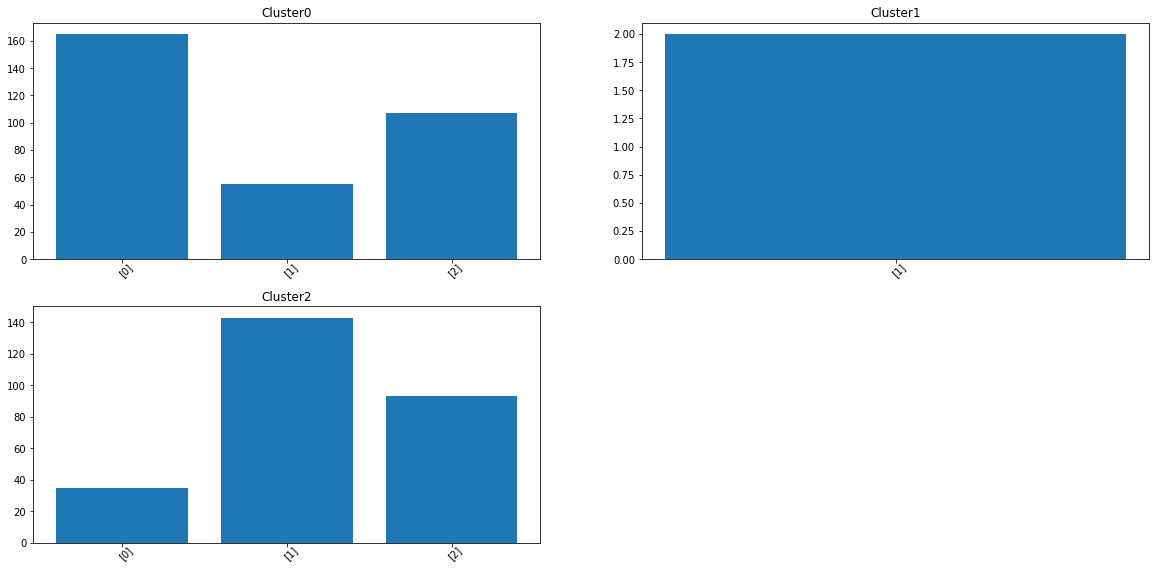

In [38]:
Clus_dataSet =features
y_train = y
y = y_train
print(y.unique())
#n_clusters = number of unique value because INDEX has 10 values. Not the best value but a simple logic.
#The value of n_init at 30 yields good results so we will use it. For confirmation us the above code.
k_means = KMeans(init = "k-means++", n_clusters = y.nunique(), n_init = 30)
#fit the data to our k_means model
k_means.fit(Clus_dataSet)


k_means_labels = k_means.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))
G = len(np.unique(k_means_labels)) #Number of labels

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(G)]
for i, label in enumerate(k_means_labels,0):
    for n in range(G):
        if label == n:
            cluster_index[n].append(i)
        else:
            continue  

# # #Visualisation for clusters = clust
# plt.figure(figsize=(20,20));
# clust = y.nunique() #enter label number to visualise
# num = 100 #num of data to visualize from the cluster
# for i in range(1,num): 
#     plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
#     plt.imshow(X[cluster_index[clust][i+1]].reshape(X_train.shape[1], X_train.shape[2]), cmap = plt.cm.binary);
    
# plt.show()

Y_clust = [[] for i in range(G)]
for n in range(G):
    Y_clust[n] = y[cluster_index[n]] #Y_clust[0] contains array of "correct" category from y_train for the cluster_index[0]
    assert(len(Y_clust[n]) == len(cluster_index[n])) #dimension confirmation

#counts the number of each category in each cluster
def counter(cluster):
    unique, counts = np.unique(cluster, return_counts=True)
    label_index = dict(zip(unique, counts))
    return label_index

label_count= [[] for i in range(G)]
for n in range(G):
    label_count[n] = counter(Y_clust[n])

label_count[1] #Number of items of a certain category in cluster 1
#A function to plot a bar graph for visualising the number of items of certain category in a cluster
def plotter(label_dict):
    plt.bar(range(len(label_dict)), list(label_dict.values()), align='center')
    a = []
    for i in [*label_dict]: a.append([i])
    plt.xticks(range(len(label_dict)), list(a), rotation=45, rotation_mode='anchor')
#Bar graph with the number of items of different categories clustered in it
plt.figure(figsize=(20,20))
for i in range (1,(y.nunique())+1):
    plt.subplot(4, 2, i)
    plotter(label_count[i-1]) 
    plt.title("Cluster" + str(i-1))
plt.show()

In [33]:
tsne = TSNE(n_components=2)
digit_features_tsne = tsne.fit_transform(features)

In [34]:
y = sample.label

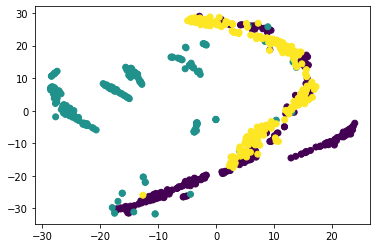

In [35]:
plt.scatter(digit_features_tsne[:,0], digit_features_tsne[:,1], c=y)

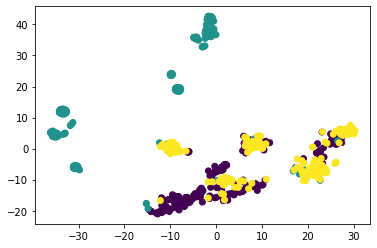

In [153]:
plt.scatter(digit_features_tsne[:,0], digit_features_tsne[:,1], c=y)

In [58]:
import pandas as pd

tsne_df = tsne_df = pd.DataFrame(
    np.column_stack((digit_features_tsne, y)),
    columns = ['X', 'y', 'targets']
)

c:\Users\phili\techlabs\ai_venv\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


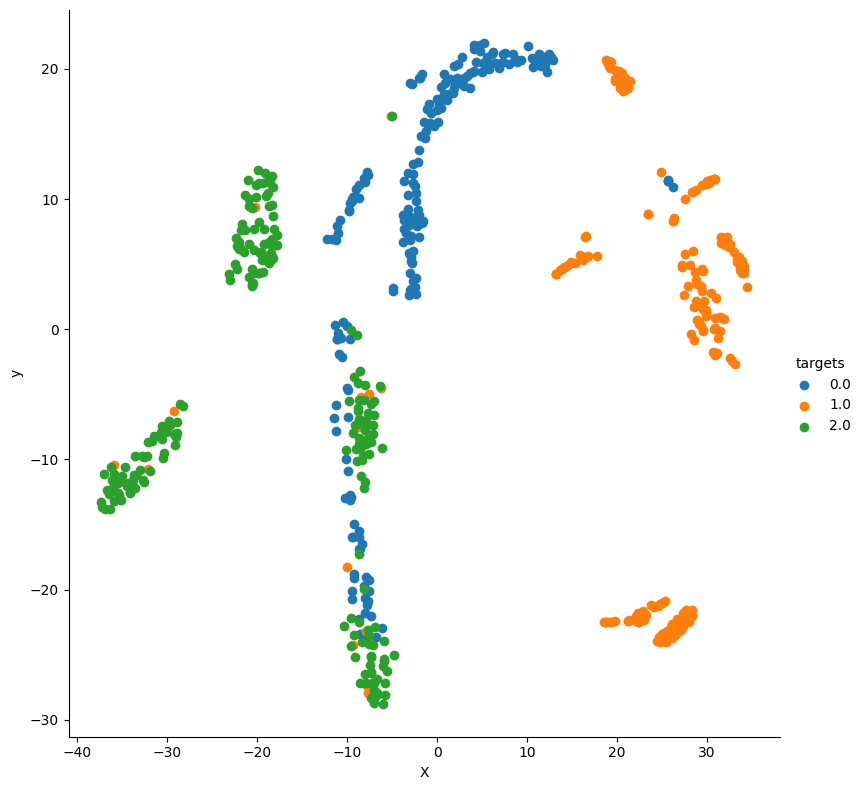

In [60]:
import seaborn as sns
grid = sns.FacetGrid(tsne_df, hue='targets', size=8)
grid.map(plt.scatter, 'X', 'y').add_legend()

Transfer Learning

In [16]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
import tensorflow as tf
# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.layers import Concatenate
import cv2

In [17]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [19]:
data = []
for i in range(len(sample.pressure)):

    img = sample.pressure[i]
    img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    reshaped_img = img.reshape(224, 224, 1)
    img_conc = Concatenate()([reshaped_img, reshaped_img, reshaped_img])
    img_conc = tf.reshape(img_conc,(1,224,224,3))
    # prepare image for model
    imgx = preprocess_input(img_conc)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    data.append(features)


In [70]:
test = np.array(data)

In [72]:
test = test.reshape(-1,len(sample))

In [61]:
len(data)

600

In [62]:
len(y)

600

In [22]:
X_train = np.array(data)
X = X_train.reshape(-1,len(sample))#We will only be using X for clustering. No need of y.

In [75]:
test.shape

(4096, 600)

In [65]:
X

array([[0.       , 5.1214557, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 3.04699  , ..., 0.       , 5.888844 ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.9012717],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 2.8837621, ..., 0.       , 1.8030102,
        0.       ]], dtype=float32)

In [24]:
from sklearn.manifold import TSNE

In [73]:
tsne = TSNE(n_components=2)
# digit_features_tsne = tsne.fit_transform(X)
digit_features_tsne = tsne.fit_transform(test)

In [39]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [51]:
sample.label = sample.label.astype(str)
sample.label = le.fit_transform(sample.label.values)

In [57]:
y = sample.label

In [58]:
y = np.array(y)

In [59]:
len(y)

600

In [54]:
y = y.reshape(-1,1)

In [60]:
len(X)

4096

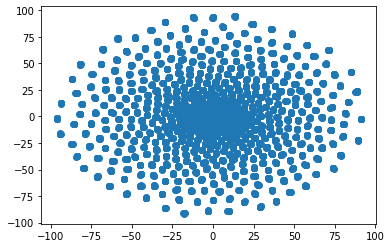

In [74]:
plt.scatter(digit_features_tsne[:,0], digit_features_tsne[:,1])